## Day 27 Lecture 2 Assignment

In this assignment, we will learn about interpreting linear models. We will use the google play store dataset loaded below and analyze the regression from this dataset.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.stats.api as sms 

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, quantile_transform

from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor


from scipy import stats
from scipy.stats import bartlett
from scipy.special import boxcox1p
from scipy.stats import levene


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

In [4]:
reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We will predict app ratings using other features describing the app. Recall from the previous assignment our data cleansing steps and do the following:

1. Remove the following columns: app, category, size, installs, genres, last updated, current ver, android ver
2. Convert all columns to numeric and remove rows where this conversion causes null values
3. Split the data into test and train subsets with 20% of the data in the test set
4. Normalize the data with QuantileTransformer. Many of the features are highly skewed.

In [5]:
# answer below:
reviews = reviews.drop(
    columns=[
        "App",
        "Category",
        "Size",
        "Installs",
        "Genres",
        "Last Updated",
        "Current Ver",
        "Android Ver",
    ]
)

reviews = reviews.dropna()

reviews = reviews[reviews["Content Rating"] != "Adults only 18+"]
reviews = reviews[reviews["Content Rating"] != "Unrated"]

content_ratings = {"Everyone": 1, "Teen": 2, "Mature 17+": 4, "Everyone 10+": 3}
reviews["Content Rating"] = reviews["Content Rating"].replace(
    to_replace=content_ratings
)

reviews = pd.get_dummies(reviews, columns=["Type"])
reviews = reviews.drop(columns=["Type_Free"])

reviews["Price"] = reviews["Price"].str.replace("$", "").astype("float")

reviews["Reviews"] = reviews["Reviews"].astype("int")

reviews.head()


,Rating,Reviews,Price,Content Rating,Type_Paid
0,4.1,159,0.0,1,0
1,3.9,967,0.0,1,0
2,4.7,87510,0.0,1,0
3,4.5,215644,0.0,2,0
4,4.3,967,0.0,1,0


In [6]:
X = reviews.drop(columns=["Rating"])
y = reviews["Rating"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
X_train_qt = quantile_transform(X_train, output_distribution='normal', random_state=42, copy=True)
X_test_qt = quantile_transform(X_test, output_distribution='normal', random_state=42, copy=True)

Create a linear regression model using statsmodels. Look at the coefficient values and their associated p values. Additionally, check model assumptions of homoscedacity, normality of errors, and multicollinearity.

In [9]:
#answer below:
X_train_qt_const = sm.add_constant(X_train_qt)
X_test_qt_const = sm.add_constant(X_test_qt)

model_1 = sm.OLS(y_train, X_train_qt_const).fit()

In [10]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     82.88
Date:                Tue, 01 Sep 2020   Prob (F-statistic):           5.84e-69
Time:                        16:59:28   Log-Likelihood:                -5488.5
No. Observations:                7489   AIC:                         1.099e+04
Df Residuals:                    7484   BIC:                         1.102e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0526      0.091     44.443      0.000       3.874       4.231
x1             0.0993      0.006     17.638      0.000       0.088       0.110
x2            -0.1195      0.055     -2.177      0.030      -0.227      -0.012
x3            -0.0033      0.002     -1.728      0.084      -0.007       0.000
x4             0.0970      0.038      2.579      0.010       0.023       0.171
==============================================================================
Omnibus:                     2230.993   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9465.045
Skew:                          -1.407   Prob(JB):                         0.00
Kurtosis:                       7.734   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Check for homoscedasicity
* plot residuals vs predictions
* Breusch-Pagan

In [11]:
y_train_pred = model_1.predict(X_train_qt_const)
resid_train = model_1.resid

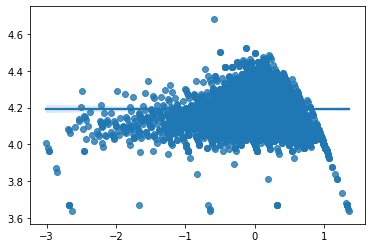

In [12]:
sns.regplot(resid_train,y_train_pred)

In [13]:
_, p, _, _ = sms.het_breuschpagan(model_1.resid, model_1.model.exog)
p

8.924081002136155e-221

In [27]:
# reviews['log_ratings'] = np.log(reviews['Rating'])
X = reviews.drop(columns=['Rating', 'Type_Paid'])
y = reviews['Rating']

In [28]:
lam = 0.15 
y = boxcox1p(y, lam)

In [29]:
lam = 0.15 
for feat in X.columns: 
    X[feat] = boxcox1p(X[feat], lam)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# y_train_bxcx = boxcox1p(y_train)


X_train_qt = quantile_transform(X_train, output_distribution='normal', random_state=42, copy=True)
X_test_qt = quantile_transform(X_test, output_distribution='normal', random_state=42, copy=True)

X_train_qt_const = sm.add_constant(X_train_qt)
X_test_qt_const = sm.add_constant(X_test_qt)

model_2 = sm.OLS(y_train, X_train_qt_const).fit()
_, p, _, _ = sms.het_breuschpagan(model_2.resid, model_2.model.exog)
p

1.9903890762063697e-163

In [31]:
y_train_pred = model_2.predict(X_train_qt_const)
resid_train = model_2.resid

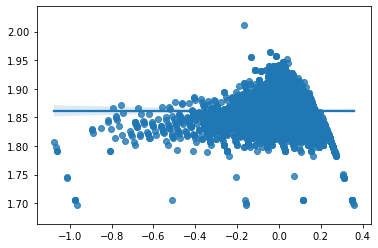

In [32]:
sns.regplot(resid_train,y_train_pred)

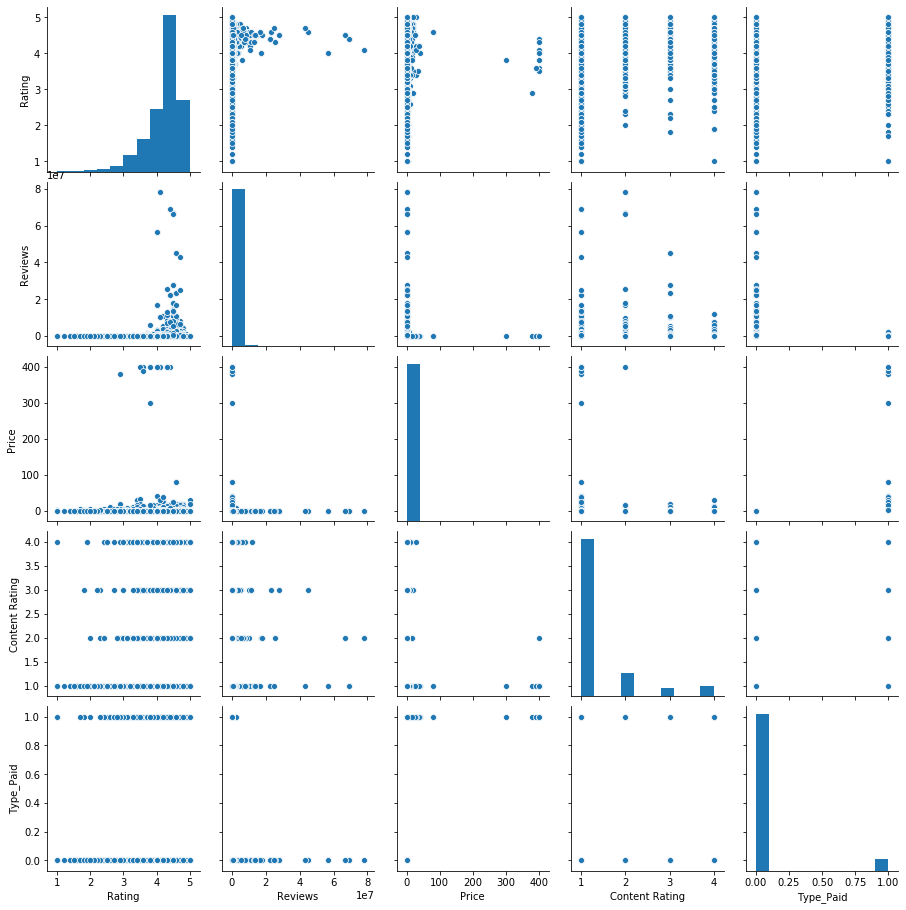

In [23]:
sns.pairplot(reviews)

In [24]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9362 entries, 0 to 10840
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rating          9362 non-null   float64
 1   Reviews         9362 non-null   int32  
 2   Price           9362 non-null   float64
 3   Content Rating  9362 non-null   int64  
 4   Type_Paid       9362 non-null   uint8  
dtypes: float64(2), int32(1), int64(1), uint8(1)
memory usage: 658.3 KB


Using the information above, try to select only the variables you think will lead to a better model and construct that model. Print out a summary

In [20]:
# sns.pairplot(reviews.drop(columns=['log_ratings']))

In [21]:
#answer below:



Plot the scatterplots between the independent variables you select and ratings. Do you think given these graphs, these variables have good predictive power? 

In [22]:
# answer below:



What data processing could you do to improve this model? Experiment.